# Идентификация пользователей по посещенным веб-страницам

Ниже представлен пайплайн разработки алгоритма, который будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же пользователем, и определять, Элис это или взломщик (кто-то другой). Более подробное описание задачи содержится в описании [соревнования](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/overview). 

**Ниже представлена навигация по основным пунктам пайплайна:**
* [Описание исходных данных](#Описание-исходных-данных)
* [Исследование исходных данных](#Исследование-исходных-данных)
* [Генерация дополнительных фичей](#Генерация-дополнительных-признаков)

# Описание исходных данных

[Исходные данные](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/data) содержат следующие файлы: 
* `train_sessions.csv`
* `test_sessions.csv`
* `site_dic.pkl`
* `train.zip`

`train_sessions.csv` и `test_sessions.csv` представляют собой сессии (последовательности посещённых пользователем сайтов) размером не более 10 сайтов и продолжительностью не более 30 минут. Сессии содержат следующие столбцы:
* site_i -- id j-го сайта, посещённого пользователем. Соответствие id-сайт представлено в словаре `site_dic.pkl`
* time_j -- время посещения соответствующего сайта
* target -- отметка сессий выполненных Alice (1-Alice, 0-noAlice)

Дополнительно в архиве `train.zip` представленны исходные данные, из которых формировались тренировочные сессии.

# Импорт библиотек и служебные функции

In [116]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# plotting lib's
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
# sklearn
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score , roc_curve, auc
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC
# support
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
import os
# does it need?
# from __future__ import division, print_function
# from sklearn.metrics import confusion_matrix
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.model_selection import cross_val_predict, TimeSeriesSplit
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [8]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

# Исследование исходных данных

**Загрузим исходные данные**

In [9]:
# path to data
PATH_TO_DATA = os.path.join('.', '..', 'data', 'kaggle')

In [17]:
# readind train and test datasets
time_columns = ['time%s' % i for i in range(1, 11)]
site_columns = ['site%s' % i for i in range(1, 11)]

train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id',
                       parse_dates=time_columns)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id',
                      parse_dates=time_columns)
# reading sites mapping
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as fo:
    site_dic = pickle.load(fo)

In [15]:
print('{} last session in train'.format(train_df['time1'].max()))
print('{} first session in test'.format(test_df['time1'].min()))

2014-04-30 23:39:53 last session in train
2014-05-01 17:14:03 first session in test


**Видно, что тренировочная и тестовая выборки разделены по времени, поэтому имеет смысл делить тренировочную выборку на обучение и валидацию также по времени**

In [14]:
# sort data
train_df = train_df.sort_values(by='time1')

In [16]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


**Краткая сводка по данным**

253561 sessions in train dataset
82797 sessions in test dataset


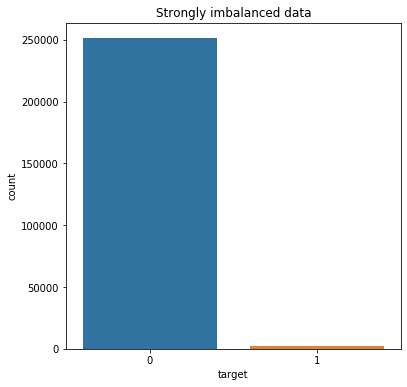

In [104]:
print('{} sessions in train dataset'.format(len(train_df)))
print('{} sessions in test dataset'.format(len(test_df)))

fig, axes = plt.subplots(1, 1, figsize=(6, 6))
sns.countplot(train_df.target, ax=axes)
axes.set_title('Strongly imbalanced data')
pass

**Проверим сохраниться ли отношение классов при делении на обучающую и валидационную выборки**

In [125]:
tscv = TimeSeriesSplit(n_splits=10)
for train_index, valid_index in tscv.split(train_df):
    train_ratio = (train_df.iloc[train_index, -1] == 1).sum() / (train_df.iloc[train_index, -1] == 0).sum()
    tvalid_ratio = (train_df.iloc[valid_index, -1] == 1).sum() / (train_df.iloc[valid_index, -1] == 0).sum()
    print('train ratio {:.3f} against valid ratio {:.3f}'.format(train_ratio, tvalid_ratio))

train ratio 0.009 against valid ratio 0.010
train ratio 0.009 against valid ratio 0.009
train ratio 0.009 against valid ratio 0.010
train ratio 0.009 against valid ratio 0.009
train ratio 0.009 against valid ratio 0.010
train ratio 0.009 against valid ratio 0.009
train ratio 0.009 against valid ratio 0.007
train ratio 0.009 against valid ratio 0.010
train ratio 0.009 against valid ratio 0.009
train ratio 0.009 against valid ratio 0.010


**Сделаем колонки посещённых сайтов типа `int` и заполним пропуски нулями**

In [21]:
train_df[site_columns] = train_df[site_columns].fillna(0).astype('int')
test_df[site_columns] = test_df[site_columns].fillna(0).astype('int')

**Посчитаем частоты встречаемости сайтов в сессиях**

In [93]:
train_freq = pd.Series(train_df[site_columns].values.flatten()).value_counts()
train_alice_freq = pd.Series(train_df[train_df.target==1][site_columns].values.flatten()).value_counts()
test_freq = pd.Series(test_df[site_columns].values.flatten()).value_counts()

site_freq = pd.DataFrame(np.zeros((len(site_dic), 5), dtype=int))
site_freq.iloc[:, 0] = site_dic.keys()
site_freq.index = np.array(list(site_dic.values()), dtype=int)
site_freq.columns = ['site', 'train_count', 'test_count', 
                     'train_alice_count', 'train_noalice_count']

for key, val in site_dic.items():
    try:
        site_freq['train_count'].loc[val] = train_freq[val]
    except:
        pass
    try:
        site_freq['train_alice_count'].loc[val] = train_alice_freq[val]
    except:
        pass
    try:
        site_freq['test_count'].loc[val] = test_freq[val]
    except:
        pass
    
site_freq['train_noalice_count'] = site_freq['train_count'] - site_freq['train_alice_count']

In [94]:
site_freq.sort_values('train_count', ascending=False).head(15)

,site,train_count,test_count,train_alice_count,train_noalice_count
21,www.google.fr,123776,37175,857,122919
23,www.google.com,87619,24243,437,87182
782,annotathon.org,77055,31755,0,77055
22,apis.google.com,58258,17655,522,57736
29,www.facebook.com,54094,19580,897,53197
167,www.bing.com,46405,15293,50,46355
780,blast.ncbi.nlm.nih.gov,43841,7511,0,43841
778,www.ncbi.nlm.nih.gov,38194,25813,0,38194
52,clients1.google.com,36085,10338,206,35879
812,mail.google.com,35178,10130,0,35178


In [95]:
site_freq.sort_values('test_count', ascending=False).head(15)

,site,train_count,test_count,train_alice_count,train_noalice_count
21,www.google.fr,123776,37175,857,122919
782,annotathon.org,77055,31755,0,77055
778,www.ncbi.nlm.nih.gov,38194,25813,0,38194
23,www.google.com,87619,24243,437,87182
1202,claroline.univ-bpclermont.fr,1677,20413,0,1677
29,www.facebook.com,54094,19580,897,53197
22,apis.google.com,58258,17655,522,57736
167,www.bing.com,46405,15293,50,46355
80,s.youtube.com,31391,14261,1354,30037
302,ent.univ-bpclermont.fr,3656,11100,0,3656


**Видно, что рейтинг встречаемости сайтов в тренировочной и тестовой хоть и достаточно близки но различаются**

**Также можно отметить, что только половина самых популярных сайтов посещалось самой Alice. Этот факт стоит учесть при составлении дополнительных признаков.**

# Генерация дополнительных признаков